## 测试网络带宽的稳定性, 以及其和transfer page的关系

qemu原端命令行:
```sh
qemu-system-x86_64 -display none  \
-vga none  \
-qmp tcp:127.0.0.1:5555,server,nowait \
-monitor tcp:127.0.0.1:6666,server,nowait \
-cpu host  \
-append "noapic edd=off printk.time=1  \
noreplace-smp cgroup_disable=memory  \
pci=noearly console=ttyS0 debug init=/sbin/init mm_dirty -m 30G -r 2000" \
-m 64G \
-smp 1 -kernel ./vmlinuz -initrd  \
./build/tests/migration/initrd-stress.img  \
--display none  \
-machine graphics=off \
-trace events=/traces.txt \
-msg timestamp=on \
-serial stdio \
-accel kvm,dirty-ring-size=$((32768))  \
```
大致信息如下:
* 64G,smp 1
* 使用peterX的`mig_mon`, 作为vm init进程，速率为2000M/s，写内存范围30G。
  > NOTE
  >
  > 之所以使用30G内存写，主要是为了避免单位时间内对同一块内存进行写操作，从而
  > 造成mig_mon设置的脏页速率，和实际的WP/PML相应的速率对不上。设置30G，脏页
  > 速率大概2G左右，需要15s才能写一轮。在后期的迭代中。可以保证这个速率很正确。

* dirty-ring size 设置为 32768（也可以设置为65535），这个无所谓，不影响热迁移效率，
  对虚拟机性能影响比较大。

* traces.txt 中开启
  + migrate_transferred
  + migrate_pending_estimate
  
得到qemu日志，使用下面代码分析:

In [2]:
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import re

def get_pattern_result(pattern,text):
    # 定义正则表达式模式
    # 使用 re.findall() 提取匹配的内容

    if re.search(pattern, text):
        matches = re.findall(pattern, text)
        # 提取结果
        return [match for group in matches for match in group if match] 
def get_every_line_from_file(filename,pattern):
    result = []
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file, start=1):
            # 去除行末的换行符
            line = line.rstrip()
            # 打印行号和每一行
            one_result=get_pattern_result(pattern,line)
            if one_result:
                result.append(get_pattern_result(pattern,line))

    return result

def fig_migrate_transfer_bandwidth(file_name):
    ## def get_bandwidth_transferred()
    ## 25612@1733451316.508848:migrate_transferred transferred 117415476 time_spent 104 bandwidth 1128994 switchover_bw 0 max_size 338698488
    ## (\d+\.\d+) 用来匹配 @后的小数
    ## r'@(\d+\.\d+).*?transferred (\d+).*?bandwidth (\d+)'
    result_migrate_transffered = get_every_line_from_file(file_name, r'@(\d+\.\d+):migrate_transferred transferred (\d+).*?bandwidth (\d+)')
    timestamp=[row[0] for row in result_migrate_transffered]
    bandwidth=[row[2] for row in result_migrate_transffered]
    
    result_migrate_pending_estimate = get_every_line_from_file(file_name, r'@(\d+\.\d+):migrate_pending_estimate.*?pending size (\d+).*?')
    
    remains=[row[1] for row in result_migrate_pending_estimate]
    array=np.array(remains)
    int_array = array.astype(int)
    diff=np.diff(int_array)

    transfer_pages=-diff
    transfer_pages=transfer_pages / 5
    transfer_pages=transfer_pages.astype(float)
    transfer_pages[transfer_pages <= 0] = np.nan

    bandwidth_trace = go.Scatter(
        x=timestamp,  
        y=bandwidth, 
        # 散点 + 线段绘图
        mode="markers + lines",  
        name="bandwidth",
        yaxis='y1'
    )  
    transfer_pages_trace = go.Scatter(
        x=timestamp,  
        y=transfer_pages, 
        # 散点 + 线段绘图
        mode="markers + lines",  
        name="transfer_pages * 2",
        yaxis='y2',
        connectgaps=True
    )
    pending_trace = go.Scatter(
        x=timestamp,  
        y=remains, 
        # 散点 + 线段绘图
        mode="markers + lines",  
        name="remains",
        yaxis='y3'
    )
    return [bandwidth_trace, transfer_pages_trace, pending_trace]
def get_fig():
    fig = go.Figure(
            layout={
                "template": "xgridoff",
                "xaxis": {
                    "tickformat": '.0f'
                },
                "yaxis": {
                    # 旋转坐标字体
                    "tickangle": 0,
                    "autorange": True,
                    "tickformat": '.0f',
                    "title": "bandwidth",
                },
                "yaxis2": {
                    "overlaying" : 'y',
                    "side":'right',
                    "tickformat": '.0f',
                    "position": 0.75,
                    "title": "transfer_pages * 2",
                },
                "yaxis3": {
                    "overlaying" : 'y',
                    "side":'right',
                    "tickformat": '.0f',
                    "position": 1,
                    "title": "remains",
                },
                "height": 500,
                
            }
        )
    return fig

def show_b_tp(file_name):
    all_trace=fig_migrate_transfer_bandwidth(file_name)
    fig=get_fig()
    fig.add_trace(all_trace[0])
    fig.add_trace(all_trace[1])
    fig.show()

def show_b_tp_pend(file_name):
    all_trace=fig_migrate_transfer_bandwidth(file_name)
    fig=get_fig()
    fig.add_trace(all_trace[0])
    fig.add_trace(all_trace[1])
    fig.add_trace(all_trace[2])
    fig.show()

简单说下各个曲线:
* bandwidth: 带宽，单位为byte，统计时间理论为100ms，但是实际为102ms+
* tranfferd: 
## 迁移测试短时间
使用上面的参数，迁移10s左右，简单看下过程。

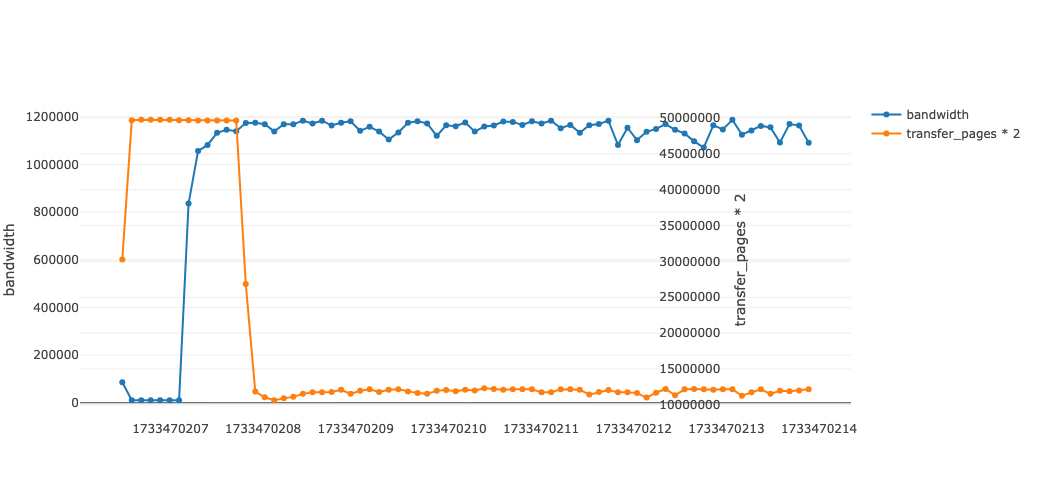

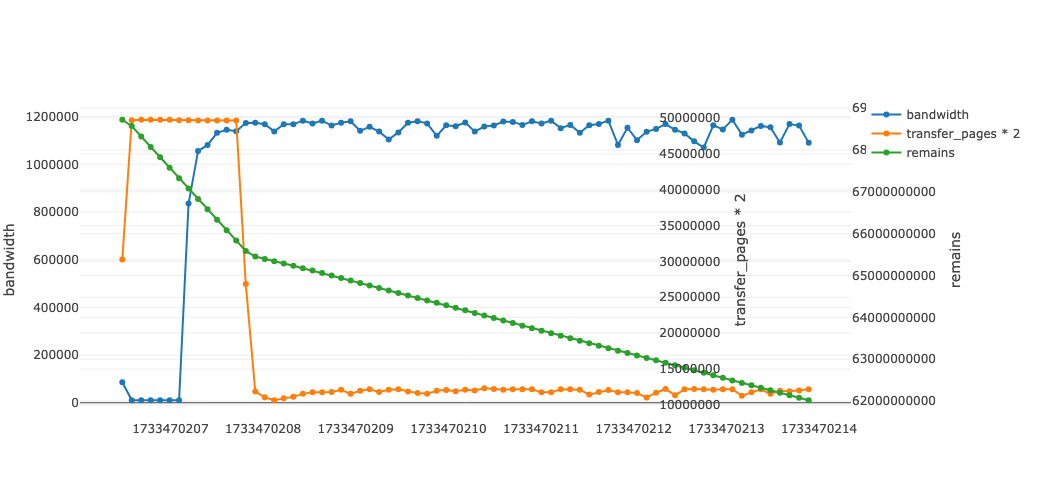

In [4]:
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import re

show_b_tp("log_short.txt")
show_b_tp_pend("log_short.txt")

在迁移初，带宽占比很低。但是transfer pages却很大。这实际表示，传输这些page占用的实际带宽不高。

个人认为是guest中有30G左右的zero page，migrate thread忙于检测zero page，造成带宽浪费（这部分不知道好不好优化下）。
但是按照peter的mig_mon, 在写mem时:

```cpp
int mon_mm_dirty(mm_dirty_args *args)
{
    ...
    unsigned char cur_val = 2;
    while(1) {
        ...
        if (pattern == PATTERN_SEQ) {
            /* Validate memory if not the first round */
            unsigned char target = cur_val - 1;

            if (*mm_ptr != target) {
                fprintf(stderr, "%s: detected corrupted memory (%d != %d)!\n",
                            __func__, *mm_ptr, target);
                exit(-1);
            }
            *mm_ptr = cur_val;
            mm_ptr += page_size;
        } else if (pattern == PATTERN_RAND) {
        ...
        if (pattern == PATTERN_SEQ && mm_ptr + N_1M > mm_end) {
            mm_ptr = mm_buf;
            cur_val++;
        }

    }
    ...
```

默认写入的值都是>0 的， 不会构造zero page。
所以，后续理论上不会造成带宽浮动。

我们再测试300s看下，整体的带款和传输transfer page 有没有明显浮动。

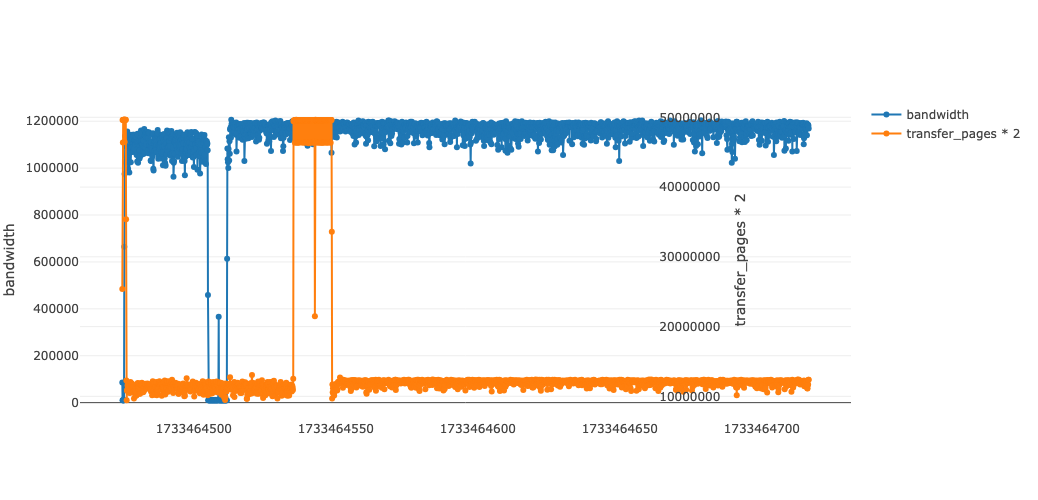

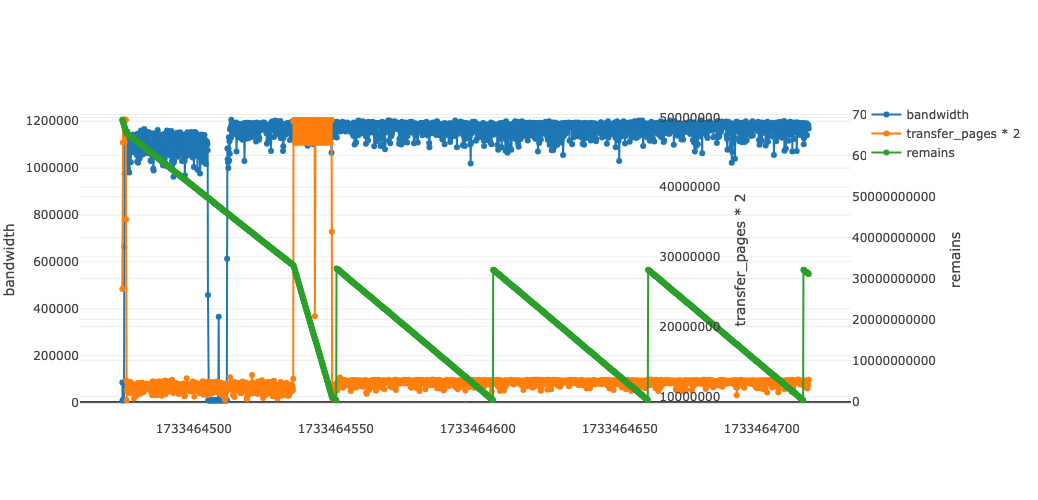

In [3]:
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import re

show_b_tp("log_short.txt")
show_b_tp_pend("log_short.txt")

可以发现整体带宽在1100mbs(+-5%), 但是期间遇到了带宽向下浮动的情况，但是未造成transfer_pages能力减少，反而在后续tranfer_pages
速率大大增加。

突出的一块，可能为连续的zero page。

## 改写mig_mon, 周期性写zero page

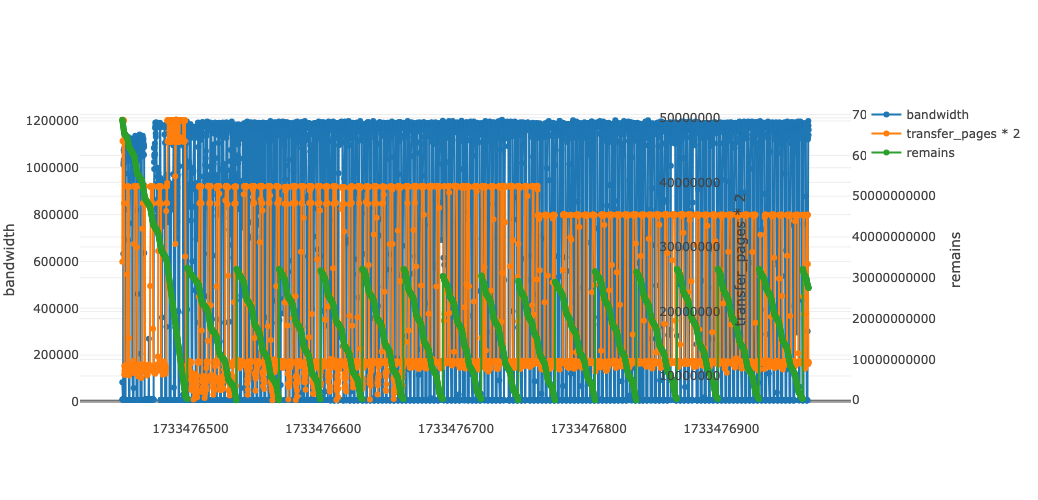

In [5]:
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import re

show_b_tp_pend("log_make_zero_page_period_500.txt")


可以发现通过周期性的触发dirty zero page，会造成实际使用带宽周期性波动。呈现出的效果也比较奇怪。
transfer pages，似乎在早期很不稳定。经常低于带宽本应能传输的page。这块需要后期在调试下，
但是随着热迁移逐步进行(200s+)，似乎比较稳定。

## 结论
目前可以暂且认为，

## multifd-100G
简单测试

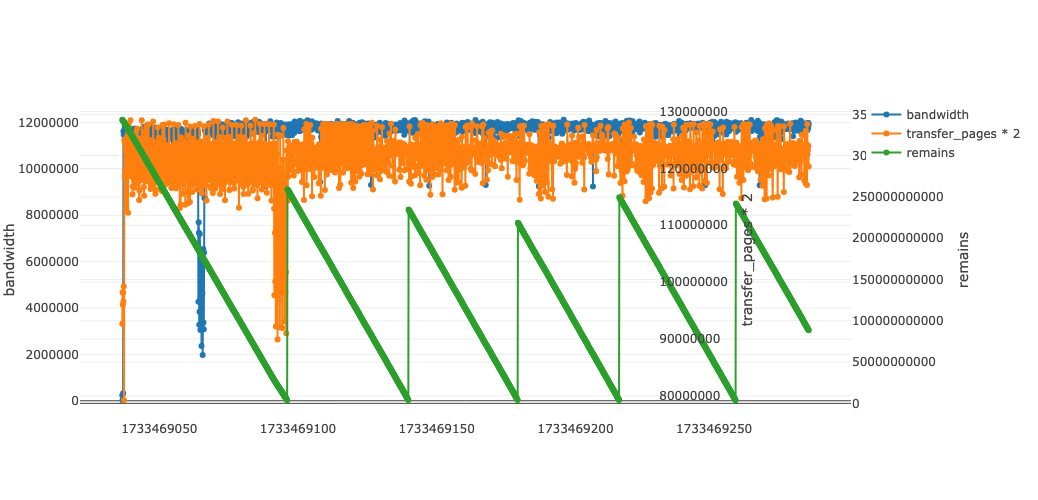

In [8]:
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import re

show_b_tp_pend("log_multifd.txt")